# Investigating the Regression Model

This code attempts to investigate the issues in the Ridge Regression model while trying to learn fmri representations from CNN embeddings

In [2]:
import sys
import numpy as np
import torch.nn as nn
sys.path.append('../')
from libs.dataloader import BOLD5000ImageNet
from libs.models import alexnet, AlexNet
from collections import OrderedDict
from pydicom import dcmread
from torch.utils.data import Dataset, DataLoader
import tqdm
import torch
import os
from sklearn.linear_model import SGDRegressor, Ridge, RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from neurora.rdm_cal import bhvRDM
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import pickle
import sklearn
from torchvision.transforms  import Resize
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
#from sklearn.preprocessing import StandardScalar



In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the Image embs and FMRI embeddings

In [4]:
img_emb_dir='/home/subho/scratch/embs/sparsity%s'
fmri_emb_dir='/home/subho/scratch/Dataset/%s/processed'

In [4]:
class ProcessedFMRI(Dataset):
    def __init__(self,fmri_emb_dir):
        self.fmri_emb_dir=fmri_emb_dir
    def __len__(self):
        return 1916
    def __getitem__(self,idx):
        fmri=torch.load(os.path.join(self.fmri_emb_dir,'%d_fmri.pt'%idx),map_location='cpu')
        return fmri

In [5]:
class ProcessedEMB(Dataset):
    def __init__(self,img_emb_dir):
        self.img_emb_dir=img_emb_dir
    def __len__(self):
        return 1916
    def __getitem__(self,idx):
        img=torch.load(os.path.join(self.img_emb_dir,'%d_emb.pt'%idx),map_location='cpu')
        return img

In [7]:
test=ProcessedEMB(img_emb_dir%0)
test[0].shape

torch.Size([1, 9216])

In [6]:
results=[]

### Start with fetching the fmri embs for one subject

In [7]:
csi='CSI1'

In [8]:
dataset=ProcessedFMRI(fmri_emb_dir%csi)
fmri_embs=[]
resize=Resize(size=(120,120),interpolation=InterpolationMode.NEAREST)
for i in tqdm.tqdm(range(len(dataset))):
    fmri=dataset[i]
    fmri=resize(fmri)
    fmri=(fmri[2:4]/2047).mean(axis=0)
    fmri_embs.append(fmri)
fmri_embs=np.stack(fmri_embs,axis=0)
fmri_embs=fmri_embs.reshape(1916,-1)

100%|██████████| 1916/1916 [08:11<00:00,  3.90it/s]


In [9]:

sparsity=0

dataset=ProcessedEMB(img_emb_dir%sparsity)
img_embs=[]
for i in tqdm.tqdm(range(len(dataset))):
    img=dataset[i]
    img_embs.append(img.detach().numpy())
img_embs=np.concatenate(img_embs,axis=0)
    #k_fold_linear_regression(fmri_embs,img_embs)

100%|██████████| 1916/1916 [03:08<00:00, 10.18it/s]


Lets train twovstwo using all the voxels. Let's try to identify which of the voxels are highly predictive

In [107]:
np.random.seed(49)
#scaler=StandardScaler()
#fmri_embs=scaler.fit_transform(fmri_embs)
input_dim=img_embs.shape[1]
output_dim=fmri_embs.shape[1]


kf=sklearn.model_selection.KFold(10,shuffle=True,random_state=49)
k_fold_scores_clf=[]
voxel_all_preds=[]
for train_index, test_index in tqdm.tqdm(kf.split(img_embs)):
    img_embs_train,img_embs_test=img_embs[train_index],img_embs[test_index]
    fmri_embs_train,fmri_embs_test=fmri_embs[train_index],fmri_embs[test_index]
    model=RidgeCV(normalize=True,alphas=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000],alpha_per_target=True)
    print("Fitting model")
    model.fit(img_embs_train,fmri_embs_train)

    #Evaluate on the test set
    #Calculate the regression loss
    img_embs_test_shuffled=img_embs_test.copy()
    img_embs_test_shuffled=img_embs_test_shuffled[np.random.permutation(img_embs_test.shape[0])]
    pred_embs_correct=model.predict(img_embs_test)
    pred_embs_shuffled=model.predict(img_embs_test_shuffled)
    #Calculate the two-choice classification score - Whole brain classification score 
    euclid_correct=euclidean_distances(pred_embs_correct,fmri_embs_test).diagonal()
    euclid_shuffled=euclidean_distances(pred_embs_shuffled,fmri_embs_test).diagonal()
    voxel_dist_correct=(pred_embs_correct-fmri_embs_test)**2
    voxel_dist_shuffled=(pred_embs_shuffled-fmri_embs_test)**2
    voxel_dist_stacked=np.stack([voxel_dist_correct,voxel_dist_shuffled],axis=-1)
    voxel_clf= (np.argmin(voxel_dist_stacked,axis=-1)==0)*1
    voxel_all_preds.append(voxel_clf)
    clf_sum=np.sum(np.stack([euclid_correct,euclid_shuffled],axis=1).argmin(axis=1)==0)
    #print(clf_sum/img_embs_test.shape[0])
    k_fold_scores_clf.append(clf_sum)
twovstwoscore=np.sum(k_fold_scores_clf)/img_embs.shape[0]
voxel_all_preds=np.concatenate(voxel_all_preds,axis=0)

0it [00:00, ?it/s]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
1it [00:42, 42.59s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
2it [01:24, 41.93s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
3it [02:04, 41.30s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
4it [02:45, 41.05s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
5it [03:25, 40.70s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
6it [04:07, 41.19s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
7it [04:47, 40.92s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
8it [05:26, 40.27s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
9it [06:07, 40.43s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
10it [06:47, 40.80s/it]


In [108]:
twovstwoscore

0.5292275574112735

In [90]:
voxel_all_preds_backup=voxel_all_preds.copy()

In [91]:
voxel_all_preds[:,(fmri_embs.mean(axis=0)==0)]=0

In [95]:
voxel_acc=np.mean(voxel_all_preds,axis=0)

In [101]:
np.sum(voxel_acc>0.52)

1532

In [102]:
good_vox=voxel_acc>0.52

None of the voxels can predict with greater than 60% certainity.

Now, lets try to evaluate the accuracy with only voxels that have atleast 52% accuracy

In [1]:
input_dim=img_embs.shape[1]
output_dim=fmri_embs.shape[1]

NameError: name 'img_embs' is not defined

In [105]:
np.random.seed(49)
#scaler=StandardScaler()
#fmri_embs=scaler.fit_transform(fmri_embs)
input_dim=img_embs.shape[1]
output_dim=fmri_embs.shape[1]


kf=sklearn.model_selection.KFold(10,shuffle=True,random_state=49)
k_fold_scores_clf=[]
for train_index, test_index in tqdm.tqdm(kf.split(img_embs)):
    img_embs_train,img_embs_test=img_embs[train_index],img_embs[test_index]
    fmri_embs_train,fmri_embs_test=fmri_embs[train_index],fmri_embs[test_index]
    model=RidgeCV(normalize=True,alphas=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000],alpha_per_target=True)
    print("Fitting model")
    model.fit(img_embs_train,fmri_embs_train)

    #Evaluate on the test set
    #Calculate the regression loss
    img_embs_test_shuffled=img_embs_test.copy()
    img_embs_test_shuffled=img_embs_test_shuffled[np.random.permutation(img_embs_test.shape[0])]
    pred_embs_correct=model.predict(img_embs_test)
    pred_embs_shuffled=model.predict(img_embs_test_shuffled)
    #Calculate the two-choice classification score - Whole brain classification score 
    pred_embs_correct=pred_embs_correct[:,good_vox]
    pred_embs_shuffled=pred_embs_shuffled[:,good_vox]
    fmri_embs_test=fmri_embs_test[:,good_vox]
    euclid_correct=euclidean_distances(pred_embs_correct,fmri_embs_test).diagonal()
    euclid_shuffled=euclidean_distances(pred_embs_shuffled,fmri_embs_test).diagonal()
    clf_sum=np.sum(np.stack([euclid_correct,euclid_shuffled],axis=1).argmin(axis=1)==0)
    #print(clf_sum/img_embs_test.shape[0])
    k_fold_scores_clf.append(clf_sum)
twovstwoscore=np.sum(k_fold_scores_clf)/img_embs.shape[0]

0it [00:00, ?it/s]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
1it [00:39, 39.18s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
2it [01:18, 39.09s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
3it [01:56, 38.87s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
4it [02:39, 40.46s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
5it [03:18, 39.92s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
6it [03:57, 39.69s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
7it [04:37, 39.81s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
8it [05:17, 39.81s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
9it [05:58, 40.04s/it]

Fitting model


/home/subho/base/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,
10it [06:39, 39.92s/it]


In [106]:
twovstwoscore

0.5443632567849687

Okay, we may have improvement the score slightly by prioritising voxel but the result is still not statistically significant.

In [148]:
!pip install seaborn

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


Lets try to analyze why the Linear regression model is not able to learn while the RDMs can still give a good similarity score

In [10]:
import seaborn as sns

In [17]:
with open('../classnames.txt','r') as f:
    lines = f.readlines()
    class_names = [line.rstrip() for line in lines]

Generate the Class wise mean fmri embeddings

In [31]:
class_wise_fmri_embs={}
for i,c in enumerate(class_names):
    if c in class_wise_fmri_embs:
        class_wise_fmri_embs[c].append(fmri_embs[i])
    else:
        class_wise_fmri_embs[c]=[fmri_embs[i]]
class_wise_fmri_embs=[np.mean(class_wise_fmri_embs[k],axis=0) for k,v in class_wise_fmri_embs.items()]
class_wise_fmri_embs=np.stack(class_wise_fmri_embs,axis=0)

<AxesSubplot:>

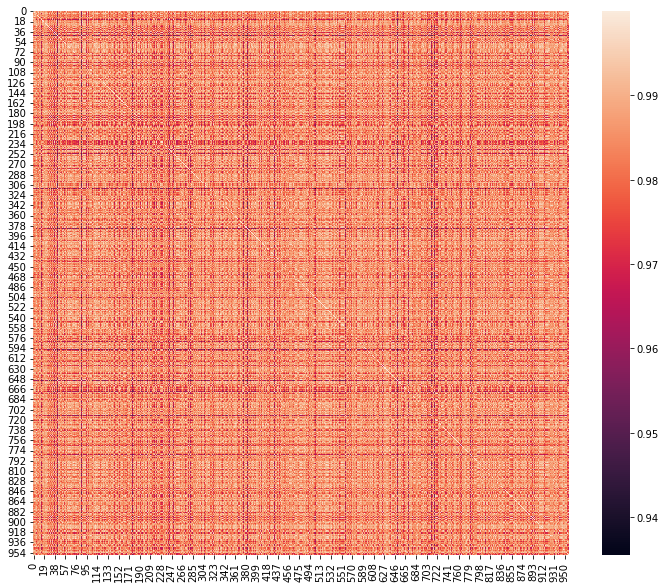

In [68]:

plt.figure(figsize=(12,10))
sns.heatmap(cosine_similarity(class_wise_fmri_embs,class_wise_fmri_embs))

<AxesSubplot:title={'center':'Classwise Dissimilarity embedding fmri'}>

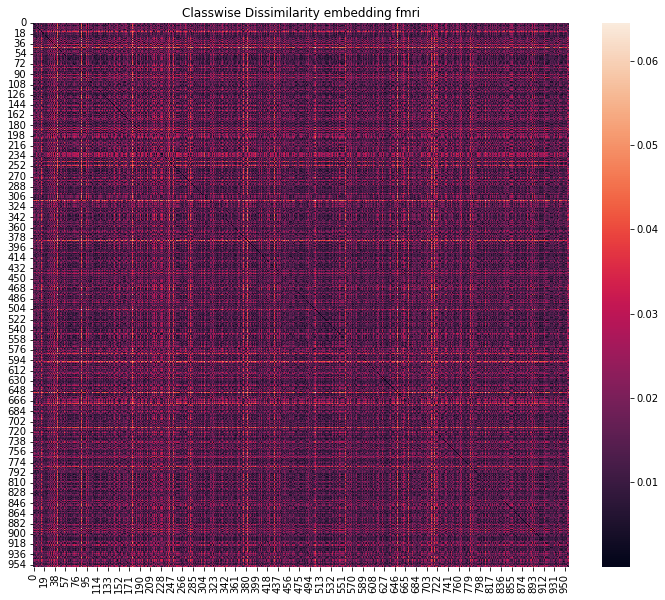

In [97]:

plt.figure(figsize=(12,10))
plt.title("Classwise Dissimilarity embedding fmri")
sns.heatmap(1-cosine_similarity(class_wise_fmri_embs,class_wise_fmri_embs))

Generate the Class wise mean image embeddings

In [35]:
class_wise_img_embs={}
for i,c in enumerate(class_names):
    if c in class_wise_img_embs:
        class_wise_img_embs[c].append(img_embs[i])
    else:
        class_wise_img_embs[c]=[img_embs[i]]
class_wise_img_embs=[np.mean(class_wise_img_embs[k],axis=0) for k,v in class_wise_img_embs.items()]
class_wise_img_embs=np.stack(class_wise_img_embs,axis=0)

In [102]:
cosine_similarity(class_wise_img_embs,class_wise_img_embs).mean()

0.27933058

<AxesSubplot:>

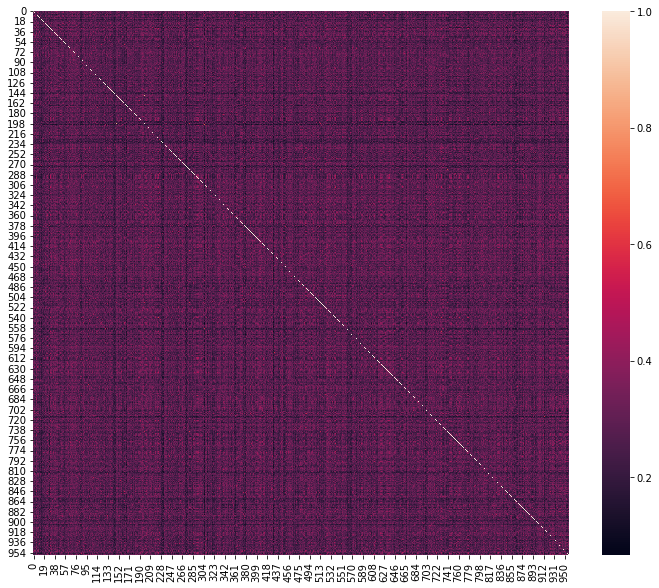

In [105]:
plt.figure(figsize=(12,10))

sns.heatmap(cosine_similarity(class_wise_img_embs,class_wise_img_embs))

The fmri features are highly correlated. The image features are not. Maybe this is why learning twovstwo classification is becoming too difficult. Does that mean the BOLD5000 data is just too noisy and biased. Or it might be an indication that regression are not probably a good approach to classify 

### Clustering of classwise fmri and image embeddings

We'll start by reducing the number of feature dimensions using TSNE

In [129]:
from sklearn.manifold import TSNE

In [147]:
fmri_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(class_wise_fmri_embs)

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(fmri_tsne[:,0],fmri_tsne[:,1])
for i,txt in enumerate(np.arange(fmri_tsne.shape[0])):
    plt.annotate(str(txt),(fmri_tsne[i,0],fmri_tsne[i,1]))

In [145]:
img_tsne=TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(class_wise_img_embs)

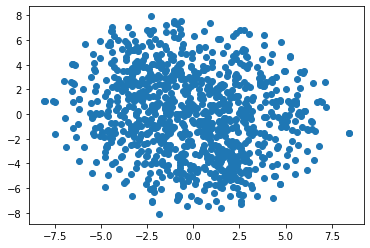

In [146]:
plt.scatter(img_tsne[:,0],img_tsne[:,1])

### Investigate why RDMs might be working

In [47]:
import rsatoolbox
from rsatoolbox import vis

In [106]:
fmri_data=rsatoolbox.data.Dataset(class_wise_fmri_embs)
fmri_rdm = rsatoolbox.rdm.calc_rdm(fmri_data)


<AxesSubplot:>

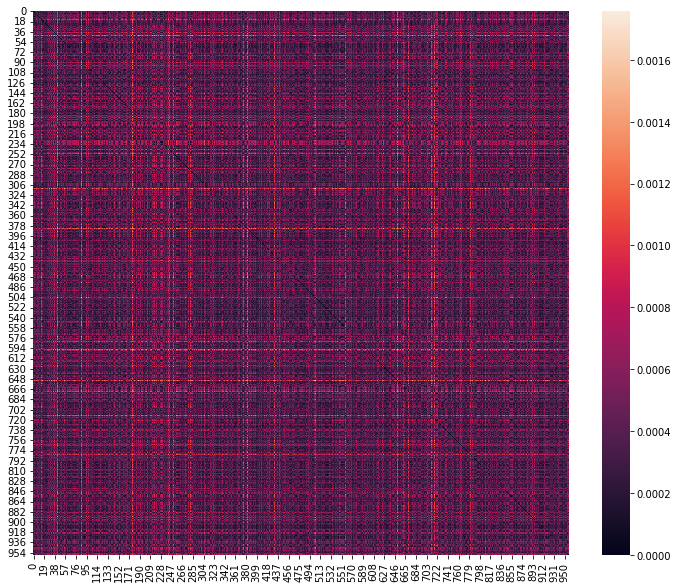

In [110]:
fmri_rdm_np=fmri_rdm.get_matrices().squeeze(0)
plt.figure(figsize=(12,10))
sns.heatmap(fmri_rdm_np)

In [112]:
img_data=rsatoolbox.data.Dataset(class_wise_img_embs)
img_rdm = rsatoolbox.rdm.calc_rdm(img_data)

<AxesSubplot:>

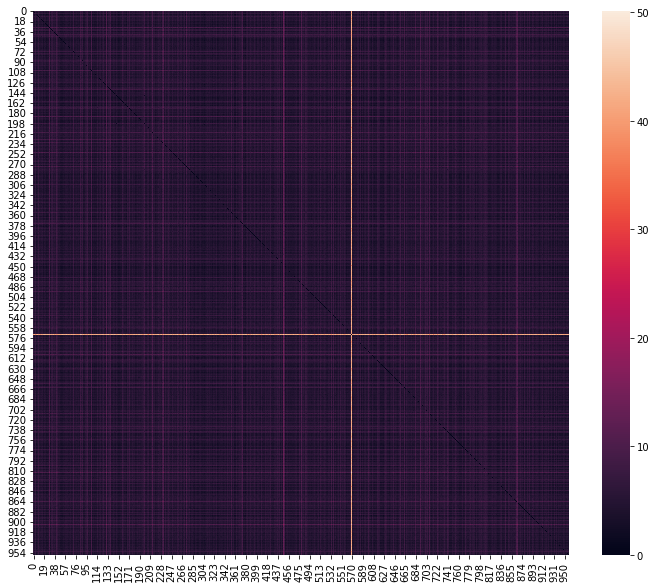

In [114]:
img_rdm_np=img_rdm.get_matrices().squeeze(0)
plt.figure(figsize=(12,10))
sns.heatmap(img_rdm_np)

In [122]:
cosine_similarity(img_rdm_np.reshape(1,-1),fmri_rdm_np.reshape(1,-1))

array([[0.82028149]])